<a href="https://colab.research.google.com/github/ECV21/data-science-portafolio/blob/main/ejercicio_rentabilidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#creación de datos ficticios

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# Configuración inicial
np.random.seed(42)
random.seed(42)
n_rows = 3000
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
         'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

# Funciones auxiliares
def generar_fechas(n, meses):
    fechas = []
    for _ in range(n):
        año = 2023
        mes = random.choice(meses)
        dia = random.randint(1, 28)
        fechas.append(f"{dia}-{mes}-{año}")
    return fechas

def generar_estado_civil(es_payroll):
    if es_payroll:
        # Mayor probabilidad de ser soltero si es payroll
        return random.choices(['Soltero', 'Casado', 'Divorciado', 'Viudo'],
                            weights=[50, 30, 15, 5])[0]
    else:
        return random.choices(['Soltero', 'Casado', 'Divorciado', 'Viudo'],
                            weights=[30, 40, 20, 10])[0]

def generar_sexo():
    return random.choices(['Hombre', 'Mujer'], weights=[55, 45])[0]

def generar_ingreso(es_payroll, años_antiguedad):
    base = 15000 if es_payroll else 10000
    antiguedad_bonus = años_antiguedad * 500 if es_payroll else años_antiguedad * 200
    variacion = np.random.normal(0, 0.2)
    return max(8000, base + antiguedad_bonus + (base * variacion))

def generar_revene_banco(es_payroll, ingreso_mensual, años_antiguedad):
    if es_payroll:
        base = ingreso_mensual * 0.03  # 3% para payroll
        antiguedad_bonus = años_antiguedad * 0.001 * ingreso_mensual
    else:
        base = ingreso_mensual * 0.015  # 1.5% para non-payroll
        antiguedad_bonus = años_antiguedad * 0.0005 * ingreso_mensual
    variacion = np.random.normal(0, 0.1)
    return max(100, base + antiguedad_bonus + (base * variacion))

def generar_años_estudio(es_payroll):
    if es_payroll:
        return min(25, int(np.random.normal(16, 2)))
    else:
        return min(25, int(np.random.normal(12, 3)))

def determinar_payroll(años_antiguedad, estado_civil, años_estudio):
    # Puntaje basado en las condiciones requeridas
    score = 0
    score += años_antiguedad * 0.5  # Más antigüedad aumenta probabilidad de payroll
    score += 2 if estado_civil == 'Soltero' else 0
    score += (años_estudio - 12) * 0.3  # Más años de estudio aumentan probabilidad

    # Probabilidad base + ajuste por score
    prob = 0.3 + (score * 0.02)
    prob = min(0.9, max(0.1, prob))

    # Ex-payroll (2) con baja probabilidad
    if random.random() < 0.05:
        return 2

    return 1 if random.random() < prob else 0

# Generación de datos
data = []
clientes_unicos = set()

# Generar clientes únicos primero
n_clientes = int(n_rows / 12 * 1.2)  # 20% más para asegurar suficientes clientes
for cliente_id in range(1, n_clientes + 1):
    edad = random.randint(18, 70)
    años_antiguedad = random.randint(0, min(30, edad-18))
    años_estudio = generar_años_estudio(False)  # Valor inicial, se ajustará después
    estado_civil = generar_estado_civil(False)  # Valor inicial
    sexo = generar_sexo()

    # Determinar si es payroll basado en las reglas
    flag_payroll = determinar_payroll(años_antiguedad, estado_civil, años_estudio)

    # Ajustar años_estudio y estado_civil según flag_payroll
    if flag_payroll == 1:
        años_estudio = generar_años_estudio(True)
        estado_civil = generar_estado_civil(True)

    clientes_unicos.add((cliente_id, edad, años_antiguedad, años_estudio, estado_civil, sexo, flag_payroll))

# Convertir a lista para poder iterar
clientes_unicos = list(clientes_unicos)

# Generar filas por mes
for mes in meses:
    # Seleccionar clientes para este mes (algunos se repiten)
    clientes_mes = random.choices(clientes_unicos, k=int(n_rows/12))

    for cliente in clientes_mes:
        cliente_id, edad, años_antiguedad, años_estudio, estado_civil, sexo, flag_payroll = cliente
        es_payroll = flag_payroll == 1

        # Generar datos dependientes
        ingreso_mensual = generar_ingreso(es_payroll, años_antiguedad)
        revene_banco = generar_revene_banco(es_payroll, ingreso_mensual, años_antiguedad)

        # Asegurar que los ex-payroll (2) no tengan antigüedad
        if flag_payroll == 2:
            años_antiguedad = 0

        data.append([
            f"{random.randint(1,28)}-{mes}-2023",
            cliente_id,
            años_antiguedad,
            edad,
            años_estudio,
            estado_civil,
            sexo,
            round(ingreso_mensual, 2),
            round(revene_banco, 2),
            flag_payroll
        ])

# Crear DataFrame
columnas = [
    'id_Date', 'id_cliente', 'años_antiguedad_payroll', 'edad_actual',
    'años_estudio', 'estado_civil', 'sexo', 'ingreso_mensual_cliente',
    'Revene_banco', 'flag_payroll'
]

df = pd.DataFrame(data, columns=columnas)

# Verificación de las condiciones requeridas
print("\nVerificación de condiciones:")
print("1) Revene_banco promedio por tipo:")
print(df.groupby('flag_payroll')['Revene_banco'].mean())

print("\n2) Influencia de años_antiguedad en payroll:")
corr_antiguedad = df.groupby('flag_payroll')['años_antiguedad_payroll'].mean()
print(corr_antiguedad)

print("\n3) Estado civil por tipo de payroll:")
print(pd.crosstab(df['flag_payroll'], df['estado_civil'], normalize='index'))

print("\n4) Años de estudio promedio por tipo de payroll:")
print(df.groupby('flag_payroll')['años_estudio'].mean())

# Guardar en CSV
df.to_csv('dataset_bancario_payroll.csv', index=False)
print("\nDataset generado y guardado como 'dataset_bancario_payroll.csv'")


Verificación de condiciones:
1) Revene_banco promedio por tipo:
flag_payroll
0    244.713958
1    971.680239
2    262.583676
Name: Revene_banco, dtype: float64

2) Influencia de años_antiguedad en payroll:
flag_payroll
0     9.757312
1    13.140811
2     0.000000
Name: años_antiguedad_payroll, dtype: float64

3) Estado civil por tipo de payroll:
estado_civil    Casado  Divorciado   Soltero     Viudo
flag_payroll                                          
0             0.435594    0.138768  0.285625  0.140012
1             0.342880    0.108194  0.496420  0.052506
2             0.382353    0.227941  0.250000  0.139706

4) Años de estudio promedio por tipo de payroll:
flag_payroll
0    11.498444
1    15.486874
2    12.492647
Name: años_estudio, dtype: float64

Dataset generado y guardado como 'dataset_bancario_payroll.csv'


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el dataset
try:
    df
except NameError:
    df = pd.read_csv('dataset_bancario_payroll.csv')

# Mapeo de meses en español a inglés para el parsing de fechas
meses_es_to_en = {
    'Enero': 'January',
    'Febrero': 'February',
    'Marzo': 'March',
    'Abril': 'April',
    'Mayo': 'May',
    'Junio': 'June',
    'Julio': 'July',
    'Agosto': 'August',
    'Septiembre': 'September',
    'Octubre': 'October',
    'Noviembre': 'November',
    'Diciembre': 'December'
}

# Función para convertir fechas en español
def convert_spanish_date(date_str):
    for es, en in meses_es_to_en.items():
        date_str = date_str.replace(es, en)
    return pd.to_datetime(date_str, format='%d-%B-%Y')

# Convertir fechas
df['id_Date_dt'] = df['id_Date'].apply(convert_spanish_date)
df['mes'] = df['id_Date_dt'].dt.month_name()

#importación de librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

#análisis exploratorio

In [ ]:
#Ver revenue per cliente
resumen_revenue = df.groupby('flag_payroll')['Revene_banco'].agg(['sum', 'mean', 'median', 'std', 'count'])
resumen_revenue = resumen_revenue.rename(index={0: 'Non-Payroll', 1: 'Payroll', 2: 'Ex-Payroll'})

print("Resumen de revenue por tipo cliente: ")
print(resumen_revenue)

#Ver ingreso total full year
revenue_fy = df.groupby('flag_payroll')['Revene_banco'].sum()
revenue_fy = revenue_fy.rename(index={0: 'Non-Payroll', 1: 'Payroll', 2: 'Ex-Payroll'})

print()
print("Revenue Full Year por cliente Payroll y Non Payroll: ")
print(revenue_fy)

#Ver la proporción del revene por tipo payroyy y non payroll
total_revenue = df['Revene_banco'].sum()
porcentaje = (revenue_fy / total_revenue) * 100

print()
print("Porcentaje de contribución al revenue total:")
print(porcentaje.round(2).astype(str) + '%')


Resumen de revenue por tipo cliente: 
                     sum        mean  median         std  count
flag_payroll                                                   
Non-Payroll    393255.33  244.713958  218.96   95.864000   1607
Payroll       1221402.06  971.680239  900.95  429.631156   1257
Ex-Payroll      35711.38  262.583676  263.04   78.169238    136

Revenue Full Year por cliente Payroll y Non Payroll: 
flag_payroll
Non-Payroll     393255.33
Payroll        1221402.06
Ex-Payroll       35711.38
Name: Revene_banco, dtype: float64

Porcentaje de contribución al revenue total:
flag_payroll
Non-Payroll    23.83%
Payroll        74.01%
Ex-Payroll      2.16%
Name: Revene_banco, dtype: object


#visualización

(array([0, 1, 2]),
 [Text(0, 0, 'Non-Payroll'), Text(1, 0, 'Payroll'), Text(2, 0, 'Ex-Payroll')])

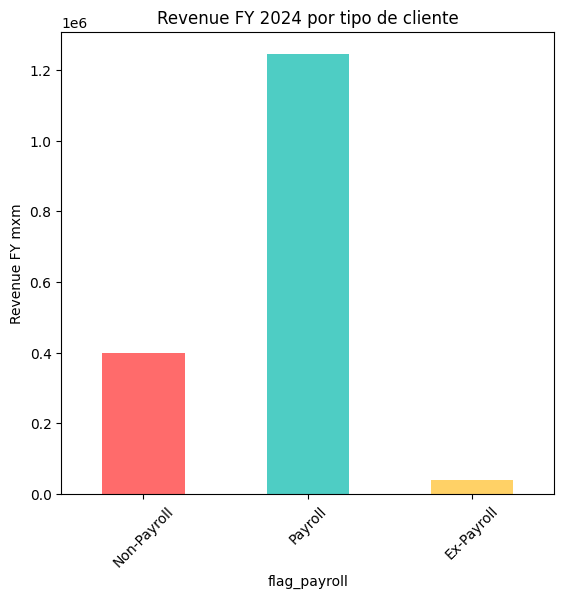

In [ ]:
# isualización de ingreso por tipocliente
plt.figure(figsize=(14, 6))

#grafico
plt.subplot(1, 2, 1)
revenue_fy.plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#FFD166'])
plt.title('Revenue FY 2024 por tipo de cliente')
plt.ylabel('Revenue FY mxm')
plt.xticks(rotation=45)

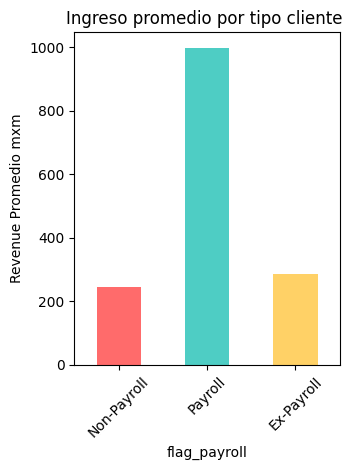

In [ ]:
#ingres pormedio fy
plt.subplot(1, 2, 2)
resumen_revenue['mean'].plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#FFD166'])
plt.title('Ingreso promedio por tipo cliente ')
plt.ylabel('Revenue Promedio mxm')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



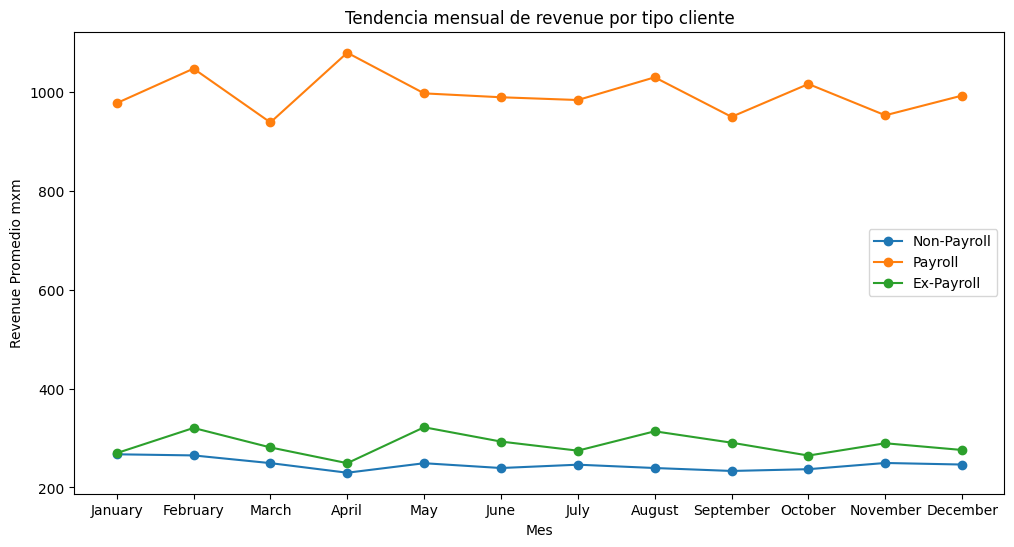

In [ ]:
#ver tendencia mensual de ingreso promedio
if 'mes' in df.columns:
    revenue_mensual = df.groupby(['mes', 'flag_payroll'])['Revene_banco'].mean().unstack()
    revenue_mensual = revenue_mensual.rename(columns={0: 'Non-Payroll', 1: 'Payroll', 2: 'Ex-Payroll'})

    #aqui ordenamos los meses
    month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']
    revenue_mensual = revenue_mensual.reindex(month_order)

    plt.figure(figsize=(12, 6))
    for col in revenue_mensual.columns:
        plt.plot(revenue_mensual.index, revenue_mensual[col], marker='o', label=col)
    plt.title('Tendencia mensual de revenue por tipo cliente')
    plt.ylabel('Revenue Promedio mxm')
    plt.xlabel('Mes')
    plt.legend()
    plt

#varibles que impactan en Payroll

###codificación de variables categóricas

In [ ]:
#convertir mi variables payroll-> 1 y non-payroll or ex-payroll --> 0
#varible sexo
#estado civil


df.head()

,id_Date,id_cliente,años_antiguedad_payroll,edad_actual,años_estudio,estado_civil,sexo,ingreso_mensual_cliente,Revene_banco,flag_payroll,id_Date_dt,mes
0,12-Enero-2023,214,3,23,13,Divorciado,Mujer,11890.75,220.61,0,2023-01-12,January
1,13-Enero-2023,279,23,63,10,Casado,Hombre,12670.15,348.80,0,2023-01-13,January
2,15-Enero-2023,186,9,32,14,Soltero,Mujer,13916.85,234.66,0,2023-01-15,January
3,28-Enero-2023,69,0,18,10,Soltero,Hombre,8000.00,100.00,0,2023-01-28,January
4,13-Enero-2023,171,1,19,9,Viudo,Hombre,9661.19,160.15,0,2023-01-13,January


###análisis ed correlación

In [ ]:
#análisis de correlación- primera exploración

#correlación punto-biserial (variable continua y flag_payroll)

In [ ]:
#correlación Phi (variable binaria y flag_payroll)

###regresion logística

In [ ]:
df.head()

,id_Date,id_cliente,años_antiguedad_payroll,edad_actual,años_estudio,estado_civil,sexo,ingreso_mensual_cliente,Revene_banco,flag_payroll,id_Date_dt,mes
0,12-Enero-2023,214,3,23,13,Divorciado,Mujer,11890.75,220.61,0,2023-01-12,January
1,13-Enero-2023,279,23,63,10,Casado,Hombre,12670.15,348.80,0,2023-01-13,January
2,15-Enero-2023,186,9,32,14,Soltero,Mujer,13916.85,234.66,0,2023-01-15,January
3,28-Enero-2023,69,0,18,10,Soltero,Hombre,8000.00,100.00,0,2023-01-28,January
4,13-Enero-2023,171,1,19,9,Viudo,Hombre,9661.19,160.15,0,2023-01-13,January


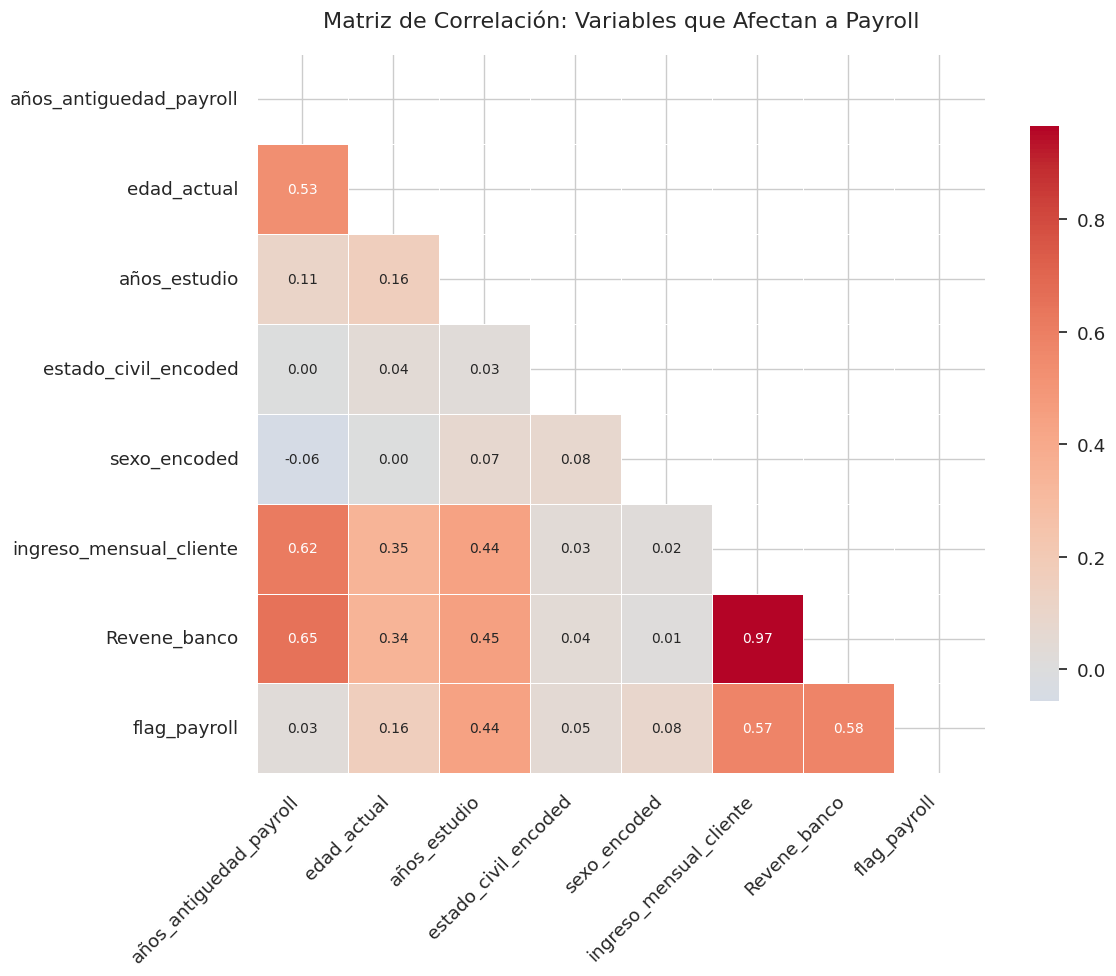


Correlación con flag_payroll (ordenadas por importancia):
flag_payroll              1.000
Revene_banco              0.576
ingreso_mensual_cliente   0.574
años_estudio              0.443
edad_actual               0.163
sexo_encoded              0.083
estado_civil_encoded      0.051
años_antiguedad_payroll   0.029


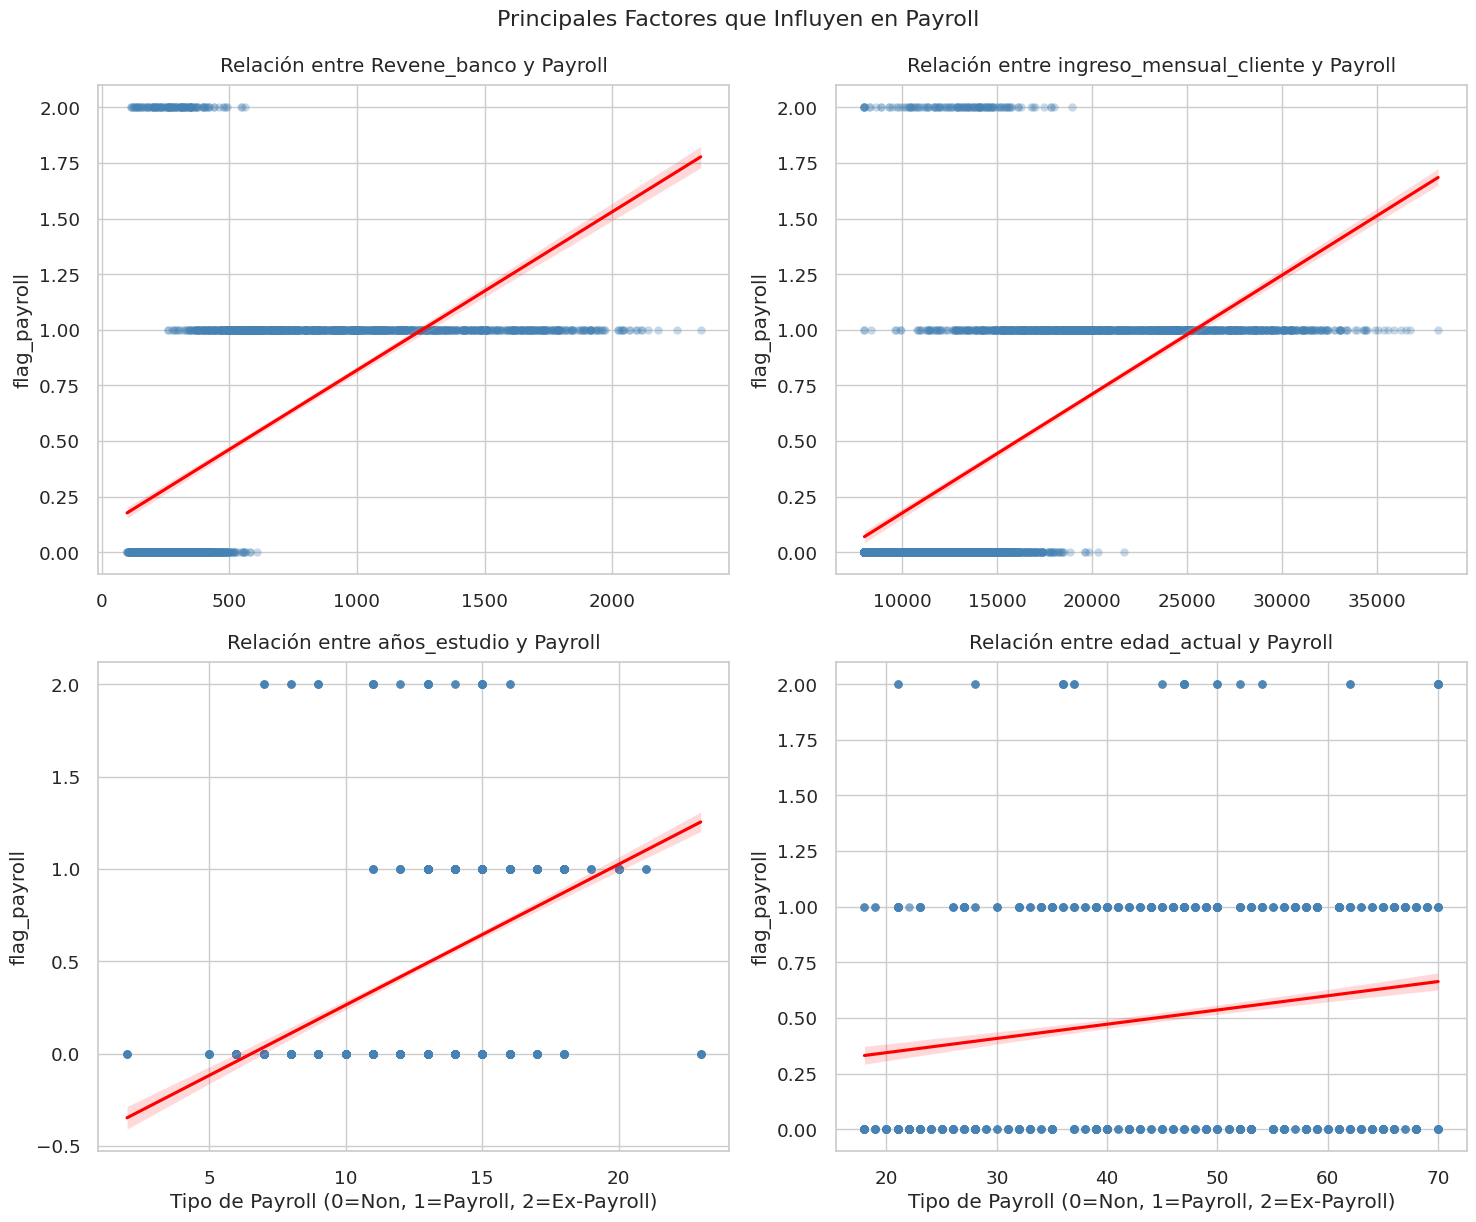


Análisis detallado por variable:

Análisis para Revene_banco:
                    mean   median         std
flag_payroll                                 
Non-Payroll   245.874227  219.615   98.472467
Payroll       997.585677  925.700  436.291413
Ex-Payroll    285.891203  281.140   99.526073

Análisis para ingreso_mensual_cliente:
                      mean     median          std
flag_payroll                                      
Non-Payroll   12002.003220  11866.625  2482.486075
Payroll       21862.968607  21434.480  5420.595573
Ex-Payroll    12885.707744  13162.040  2437.812167

Análisis para años_estudio:
                   mean  median       std
flag_payroll                             
Non-Payroll   11.464153    12.0  3.271324
Payroll       15.530825    16.0  1.806120
Ex-Payroll    11.962406    13.0  2.775450

Análisis para edad_actual:
                   mean  median        std
flag_payroll                              
Non-Payroll   42.841162    42.0  15.706023
Payroll       47

In [ ]:

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid", font_scale=1.2)
pd.set_option('display.max_columns', None)

# Cargar datos
try:
    df = pd.read_csv('dataset_bancario_payroll.csv')
except FileNotFoundError:
    raise FileNotFoundError("No se encontró el archivo 'dataset_bancario_payroll.csv'. Asegúrate de que esté en el directorio correcto.")

# Preparación de datos
# Convertir variables categóricas a numéricas
le = LabelEncoder()
df['estado_civil_encoded'] = le.fit_transform(df['estado_civil'])
df['sexo_encoded'] = le.fit_transform(df['sexo'])

# Seleccionar variables relevantes
analysis_vars = [
    'años_antiguedad_payroll',
    'edad_actual',
    'años_estudio',
    'estado_civil_encoded',
    'sexo_encoded',
    'ingreso_mensual_cliente',
    'Revene_banco',
    'flag_payroll'
]

df_analysis = df[analysis_vars]

# 1. Matriz de correlación
plt.figure(figsize=(12, 10))
corr_matrix = df_analysis.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Máscara para mostrar solo la mitad inferior

sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm',
            center=0, fmt=".2f", annot_kws={"size": 10},
            linewidths=0.5, linecolor='white', cbar_kws={"shrink": 0.8})

plt.title('Matriz de Correlación: Variables que Afectan a Payroll', pad=20, fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 2. Correlaciones con flag_payroll
print("\nCorrelación con flag_payroll (ordenadas por importancia):")
corr_with_target = corr_matrix['flag_payroll'].sort_values(key=abs, ascending=False)
print(corr_with_target.to_string(float_format="%.3f"))

# 3. Análisis de las 4 variables más relevantes
top_features = corr_with_target.index[1:5]  # Excluye la autocorrelación

# Gráficos de relación
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, feature in enumerate(top_features):
    if df[feature].nunique() > 6:  # Variables continuas
        sns.regplot(x=feature, y='flag_payroll', data=df,
                   scatter_kws={'alpha':0.3, 'color':'steelblue'},
                   line_kws={'color':'red'}, ax=axes[i])
    else:  # Variables discretas
        sns.boxplot(x='flag_payroll', y=feature, data=df,
                  palette="viridis", ax=axes[i])

    axes[i].set_title(f'Relación entre {feature} y Payroll', pad=10)
    axes[i].set_xlabel('')
    if i > 1:
        axes[i].set_xlabel('Tipo de Payroll (0=Non, 1=Payroll, 2=Ex-Payroll)')

plt.tight_layout()
plt.suptitle('Principales Factores que Influyen en Payroll', y=1.02, fontsize=16)
plt.show()

# 4. Análisis detallado por variable
print("\nAnálisis detallado por variable:")

# Función para mostrar estadísticas por grupo
def analyze_feature(feature_name):
    print(f"\nAnálisis para {feature_name}:")
    stats = df.groupby('flag_payroll')[feature_name].agg(['mean', 'median', 'std'])
    print(stats.rename(index={0: 'Non-Payroll', 1: 'Payroll', 2: 'Ex-Payroll'}))

# Analizar las variables más importantes
for feature in top_features:
    analyze_feature(feature)

# 5. Análisis de estado civil (ejemplo de variable categórica)
if 'estado_civil' in df.columns:
    print("\nDistribución de estado civil por tipo de cliente:")
    ct = pd.crosstab(df['flag_payroll'], df['estado_civil'], normalize='index')
    print(ct.rename(index={0: 'Non-Payroll', 1: 'Payroll', 2: 'Ex-Payroll'}))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 1. Selección de variables
variables = [
    'años_estudio',
    'ingreso_mensual_cliente',
    'años_antiguedad_payroll',
    'edad_actual',
    'estado_civil_encoded',
    'sexo_encoded'
]

# 2. Preparación de datos
X = df[variables]
y = df['flag_payroll']

# Escalar variables (importante para regularización)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Modelo de Regresión Logística Multinomial
model = LogisticRegression(multi_class='multinomial',
                         solver='lbfgs',
                         max_iter=1000,
                         penalty='l2')  # Regularización L2
model.fit(X_scaled, y)

# 4. Resultados
print("Coeficientes por clase:")
print("(Valores positivos aumentan la probabilidad de pertenecer a la clase)\n")

for i, class_label in enumerate(model.classes_):
    print(f"\nClase {class_label} ({['Non-Payroll', 'Payroll', 'Ex-Payroll'][class_label-1]}):")
    for j, var in enumerate(variables):
        print(f"{var:25}: {model.coef_[i][j]:.3f}")

Coeficientes por clase:
(Valores positivos aumentan la probabilidad de pertenecer a la clase)


Clase 0 (Ex-Payroll):
años_estudio             : -0.463
ingreso_mensual_cliente  : -3.335
años_antiguedad_payroll  : 4.104
edad_actual              : -0.331
estado_civil_encoded     : 0.082
sexo_encoded             : -0.161

Clase 1 (Non-Payroll):
años_estudio             : 1.294
ingreso_mensual_cliente  : 3.404
años_antiguedad_payroll  : 1.573
edad_actual              : -0.316
estado_civil_encoded     : 0.011
sexo_encoded             : 0.228

Clase 2 (Payroll):
años_estudio             : -0.831
ingreso_mensual_cliente  : -0.069
años_antiguedad_payroll  : -5.676
edad_actual              : 0.647
estado_civil_encoded     : -0.093
sexo_encoded             : -0.068


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


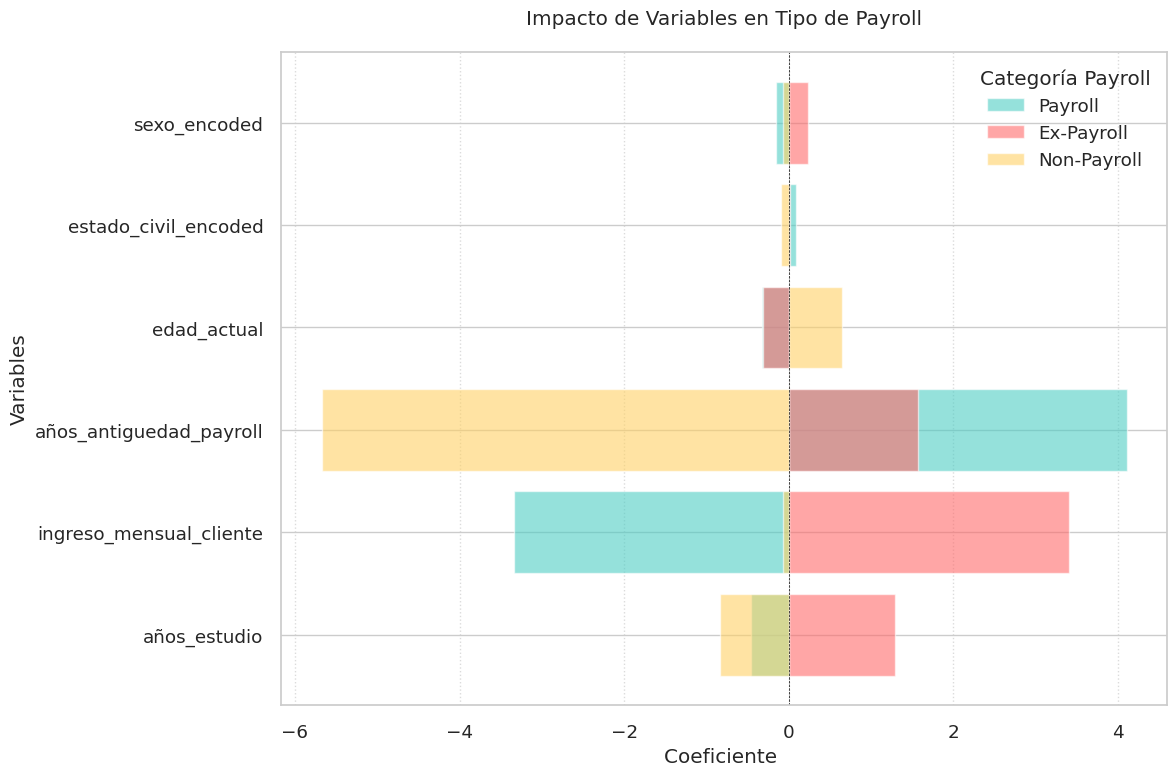

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Preparar datos para gráfico
coef_df = pd.DataFrame(model.coef_, columns=variables,
                      index=['Payroll', 'Ex-Payroll', 'Non-Payroll']).T

# Gráfico de coeficientes
plt.figure(figsize=(12, 8))
colors = ['#4ECDC4', '#FF6B6B', '#FFD166']
for i, cls in enumerate(coef_df.columns):
    plt.barh(coef_df.index, coef_df[cls],
             color=colors[i], alpha=0.6, label=cls)

plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
plt.title('Impacto de Variables en Tipo de Payroll', pad=20)
plt.xlabel('Coeficiente ')
plt.ylabel('Variables')
plt.legend(title='Categoría Payroll')
plt.grid(axis='x', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

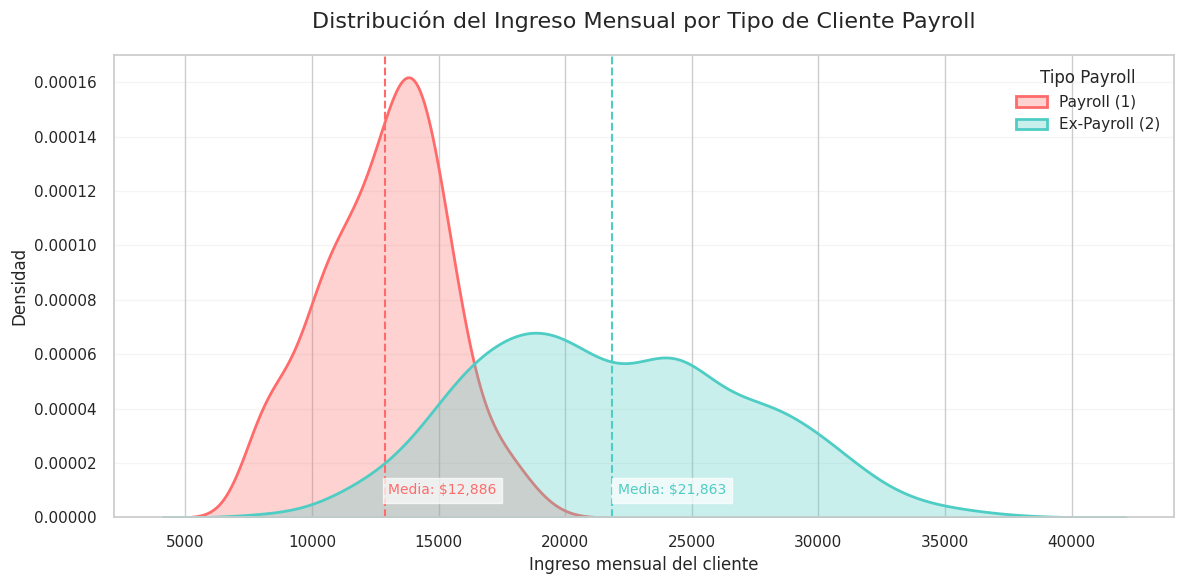

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configuración de estilo
plt.style.use('seaborn-v0_8')  # Estilo compatible con versiones recientes
sns.set_theme(style="whitegrid")  # Tema Seaborn actualizado

# Paleta de colores personalizada
paleta = ['#4ECDC4', '#FF6B6B', '#FFD166']

# 1. Gráfico de Densidad por Ingreso Mensual
plt.figure(figsize=(12, 6))
ax = sns.kdeplot(
    data=df,
    x='ingreso_mensual_cliente',
    hue='flag_payroll',
    palette=paleta,
    hue_order=[1, 2, 3],
    fill=True,
    alpha=0.3,
    linewidth=2,
    common_norm=False
)

# Personalización de etiquetas
plt.title('Distribución del Ingreso Mensual por Tipo de Cliente Payroll', fontsize=16, pad=20)
plt.xlabel('Ingreso mensual del cliente', fontsize=12)
plt.ylabel('Densidad', fontsize=12)
plt.legend(
    title='Tipo Payroll',
    labels=['Payroll (1)', 'Ex-Payroll (2)', 'Non-Payroll (3)']
)

# Añadir líneas de media del ingreso
for pay_type, color in zip([1, 2, 3], paleta):
    subset = df[df['flag_payroll'] == pay_type]['ingreso_mensual_cliente']
    if not subset.empty:
        mean_value = subset.mean()
        plt.axvline(mean_value, color=color, linestyle='--', linewidth=1.5)
        plt.text(
            mean_value + (mean_value * 0.01),
            ax.get_ylim()[1] * 0.05,
            f'Media: ${mean_value:,.0f}',
            color=color,
            fontsize=10,
            bbox=dict(facecolor='white', alpha=0.7)
        )

plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()


A mayores ingresos, hay una mayor concentración (mayor "densidad") de clientes que son "Ex-Payroll"

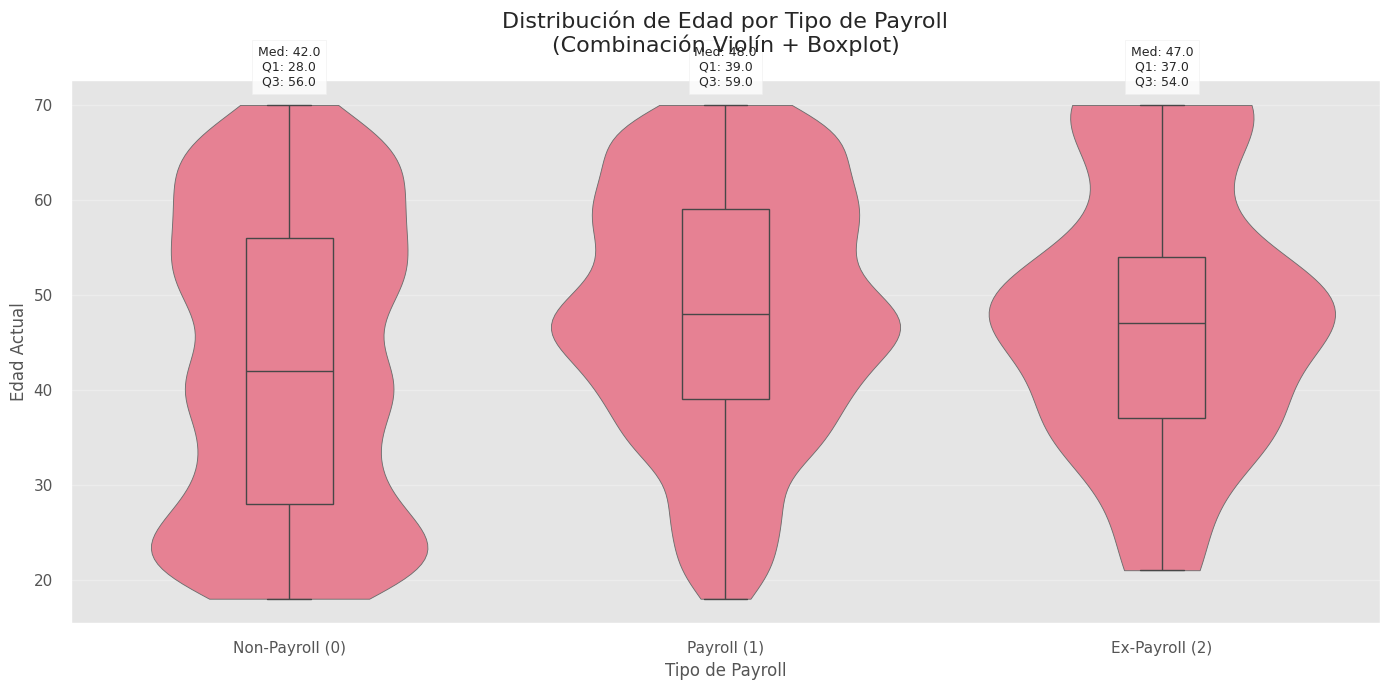

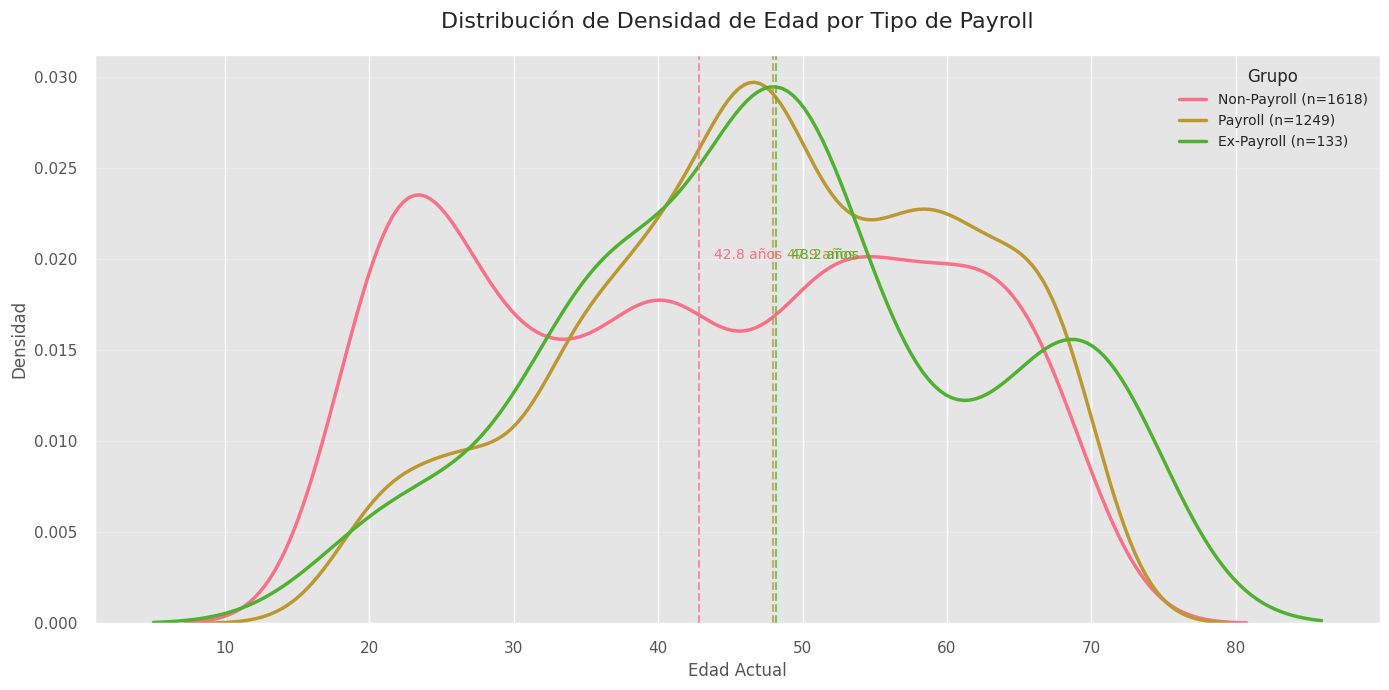

AttributeError: 'Rectangle' object has no attribute 'get_group'

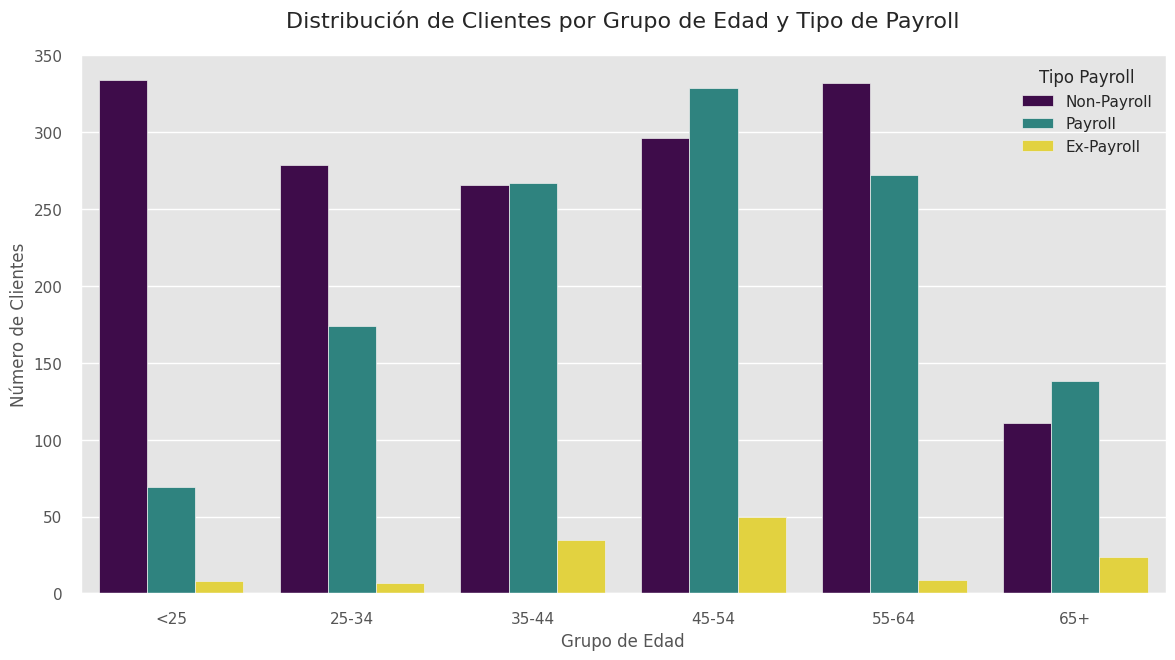

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configuración de estilo mejorada
plt.style.use('ggplot')
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'

# 1. Gráfico de Violín + Boxplot Combinado
plt.figure(figsize=(14, 7))
ax = sns.violinplot(x='flag_payroll', y='edad_actual', data=df, inner=None, cut=0)
sns.boxplot(x='flag_payroll', y='edad_actual', data=df, width=0.2, boxprops={'facecolor':'none'})

# Personalización
plt.title('Distribución de Edad por Tipo de Payroll\n(Combinación Violín + Boxplot)', fontsize=16, pad=20)
plt.xlabel('Tipo de Payroll', fontsize=12)
plt.ylabel('Edad Actual', fontsize=12)
plt.xticks([0, 1, 2], ['Non-Payroll (0)', 'Payroll (1)', 'Ex-Payroll (2)'])

# Añadir estadísticas
stats = df.groupby('flag_payroll')['edad_actual'].describe()
for i in range(3):
    median = stats.loc[i, '50%']
    q1 = stats.loc[i, '25%']
    q3 = stats.loc[i, '75%']
    plt.text(i, stats.loc[i, 'max']+2, f'Med: {median:.1f}\nQ1: {q1:.1f}\nQ3: {q3:.1f}',
             ha='center', fontsize=9, bbox=dict(facecolor='white', alpha=0.8))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Gráfico de Densidad por Grupo
plt.figure(figsize=(14, 7))
for pay_type, label in zip([0, 1, 2], ['Non-Payroll', 'Payroll', 'Ex-Payroll']):
    sns.kdeplot(df[df['flag_payroll']==pay_type]['edad_actual'],
                label=f'{label} (n={len(df[df["flag_payroll"]==pay_type])})',
                linewidth=2.5)

plt.title('Distribución de Densidad de Edad por Tipo de Payroll', fontsize=16, pad=20)
plt.xlabel('Edad Actual', fontsize=12)
plt.ylabel('Densidad', fontsize=12)
plt.legend(title='Grupo', fontsize=10)
plt.grid(axis='y', alpha=0.3)

# Añadir líneas de media
for pay_type, color in zip([0, 1, 2], sns.color_palette()[:3]):
    mean_age = df[df['flag_payroll']==pay_type]['edad_actual'].mean()
    plt.axvline(mean_age, color=color, linestyle='--', alpha=0.7)
    plt.text(mean_age+1, 0.02, f'{mean_age:.1f} años', color=color, fontsize=10)

plt.tight_layout()
plt.show()

# 3. Gráfico de Conteo por Grupos de Edad
df['grupo_edad'] = pd.cut(df['edad_actual'],
                         bins=[0, 25, 35, 45, 55, 65, 100],
                         labels=['<25', '25-34', '35-44', '45-54', '55-64', '65+'])

plt.figure(figsize=(14, 7))
count_plot = sns.countplot(x='grupo_edad', hue='flag_payroll', data=df,
                          hue_order=[0, 1, 2],
                          palette="viridis")

plt.title('Distribución de Clientes por Grupo de Edad y Tipo de Payroll', fontsize=16, pad=20)
plt.xlabel('Grupo de Edad', fontsize=12)
plt.ylabel('Número de Clientes', fontsize=12)
plt.legend(title='Tipo Payroll', labels=['Non-Payroll', 'Payroll', 'Ex-Payroll'])

# Añadir porcentajes
total_counts = df['flag_payroll'].value_counts()
for p in count_plot.patches:
    height = p.get_height()
    count_plot.text(p.get_x()+p.get_width()/2., height+3,
                   f'{height}\n({height/total_counts[p.get_group()]*100:.1f}%)',
                   ha="center", fontsize=9)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()